# Trajectory analysis - Monocytes

We have been working on various ways of representing trajectory information of subpopulations of PBMCs for some time. I think RNA Velocity in combination with PAGA. 

In [ ]:
import numpy as np
import scanpy.api as sc
import loompy
import logging
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from decimal import Decimal
import os
import scvelo as scv
from sklearn.manifold import TSNE
import argparse
import sys
####################
#  Configure file  #
####################
# Configure logging
logging.basicConfig(level=logging.INFO)
# Configure scanpy settings
sc.settings.verbosity = 2
sc.settings.autoshow = False
sc.settings.set_figure_params(dpi_save=1000, format='png')

allcellspath = '/ye/yelabstore2/10x.lupus/process.scRNAseq/Richard/PlottingScripts/ez_scanpy/CLUESImmVarMono.h5ad'
adata = sc.read(allcellspath)
print(adata)
umap = adata.obsm['X_umap']
print(umap)

sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=1000, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']

sc.pl.umap(adata, color='ct_cov', palette=color_map, show=False, save='ct_cov.png')
sc.pl.umap(adata, color='batch_cov', palette=color_map, show=False, save='batch_cov.png')
sc.pl.umap(adata, color='pop_cov', palette=color_map, show=False, save='pop_cov.png')
sc.pl.umap(adata, color='louvain', palette=color_map, show=False, save='louvian.png')
sc.pl.umap(adata, color='disease_cov', palette=color_map, show=False, save='disease_cov.png')
sc.pl.umap(adata, color=['CD14', 'FCGR3A', 'IFI6', 'LY6E', 'C1QA', 'APOBEC3A'], palette=color_map, show=False, save='Monogenes.png')
#sc.tl.rank_genes_groups(adata, groupby='louvain', n_genes=10)
#sc.pl.rank_genes_groups(adata, save='rankgenes.png')
# First PC for ordering of cells in the umap
adata.obs['dpt_pseudotime'] = sc.pp.pca(adata.obsm['X_umap'], n_comps=1, copy=True)
# You need to assign the root louvain group!
root = '2'
#adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain'] == str(root))[0]
#sc.tl.dpt(adata, n_branchings=0)
sc.pl.umap(adata, color='dpt_pseudotime', palette=color_map, show=False, save='pseudotime_monocytes.png')
#adata.obs['dpt_pseudotime'] = np.log(adata.obs['dpt_pseudotime'].values)


def pseudotime_trajectory(adata, root, path, savepath):
    adata = adata[adata.obs['louvain'].isin(path)]
    print(adata.obs['louvain'])
    # You need to assign the root louvain group!
    adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain'] == str(root))[0]
    sc.tl.dpt(adata, n_branchings=0)
    # pseudotime values for sle
    slenum = np.asarray(adata.obs['dpt_pseudotime'][adata.obs['disease_cov']=='sle'].values.tolist())
    # pseudotime values for healthy
    healthynum = np.asarray(adata.obs['dpt_pseudotime'][adata.obs['disease_cov']=='healthy'].values.tolist())

    sns.set(font_scale=0.5)
    plt.figure()
    sns.distplot(slenum, rug=False, norm_hist=False, label="sle");
    sns.distplot(healthynum, rug=False, norm_hist=False, label="healthy");
    plt.savefig(savepath)
    sc.pl.umap(adata, color='dpt_pseudotime', palette=color_map, show=False, save=savepath)
    plt.close()

pseudotime_trajectory(adata, root='10', path=['10', '1'], savepath='CD16_pseudotime_trajectory_histogram.png')
pseudotime_trajectory(adata, root='8', path=['8', '4', '2', '0'], savepath='CD14_pseudotime_trajectory_histogram.png')
pseudotime_trajectory(adata, root='2', path=['2', '0', '1'], savepath='CD14CD16_activated_pseudotime_trajectory_histogram.png')
pseudotime_trajectory(adata, root='8', path=['8', '4', '1'], savepath='CD14CD16_nonactivated_pseudotime_trajectory_histogram.png')



slenum = adata.obsm['X_umap'][adata.obs['disease_cov']=='sle']
healthynum = adata.obsm['X_umap'][adata.obs['disease_cov']=='healthy']
plt.figure()
sns.jointplot(slenum[:,0], slenum[:,1], kind="kde", space=0, color="g")
plt.savefig('SLE_Monocyte_density.png')
plt.close()
plt.figure()
sns.jointplot(healthynum[:,0], healthynum[:,1], kind="kde", space=0, color="r")
plt.savefig('Healthy_Monocyte_density.png')
plt.close()

#### Kernal Density plots and distributions for Monocytes in healthy and patients with SLE

In healthy controls, Monocytes for two clear populations of cells, CD14 and CD16. In patients with SLE, there exist more heterogeneity. It is obvious from the Kernal density plots that there exists two populations of CD14 cells and two-three populations of CD16 cells. From gene expression, we know one is non-classical monocytes and the other is a complement activated group.

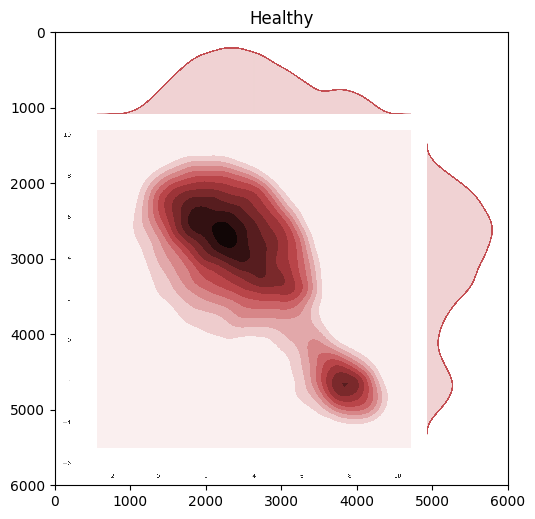

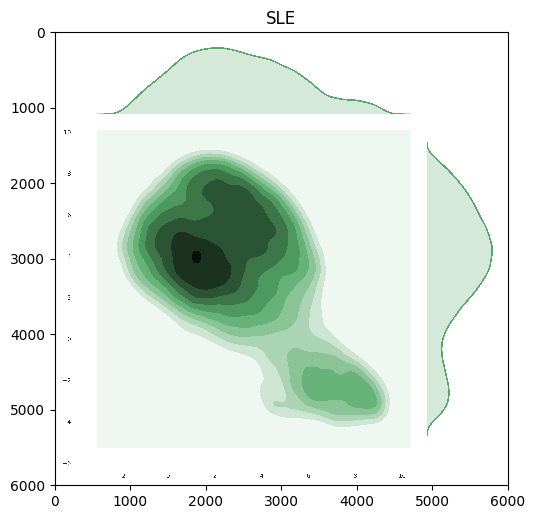

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.title('Healthy')
img=mpimg.imread('Healthy_Monocyte_density.png')

imgplot = plt.imshow(img)
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.title('SLE')
img=mpimg.imread('SLE_Monocyte_density.png')
imgplot = plt.imshow(img)

#### Inital RNA velocity

RNA velocity demonstrates active mRNA turnover in complement associated and APOBEC3B associated louvain groups in patients with SLE but not in healthy. Additionally, We some activity in non-activated CD14 monocytes in healthy controls. We do not see a trajectory between CD14 and CD16 cells which we initially thought we would see.

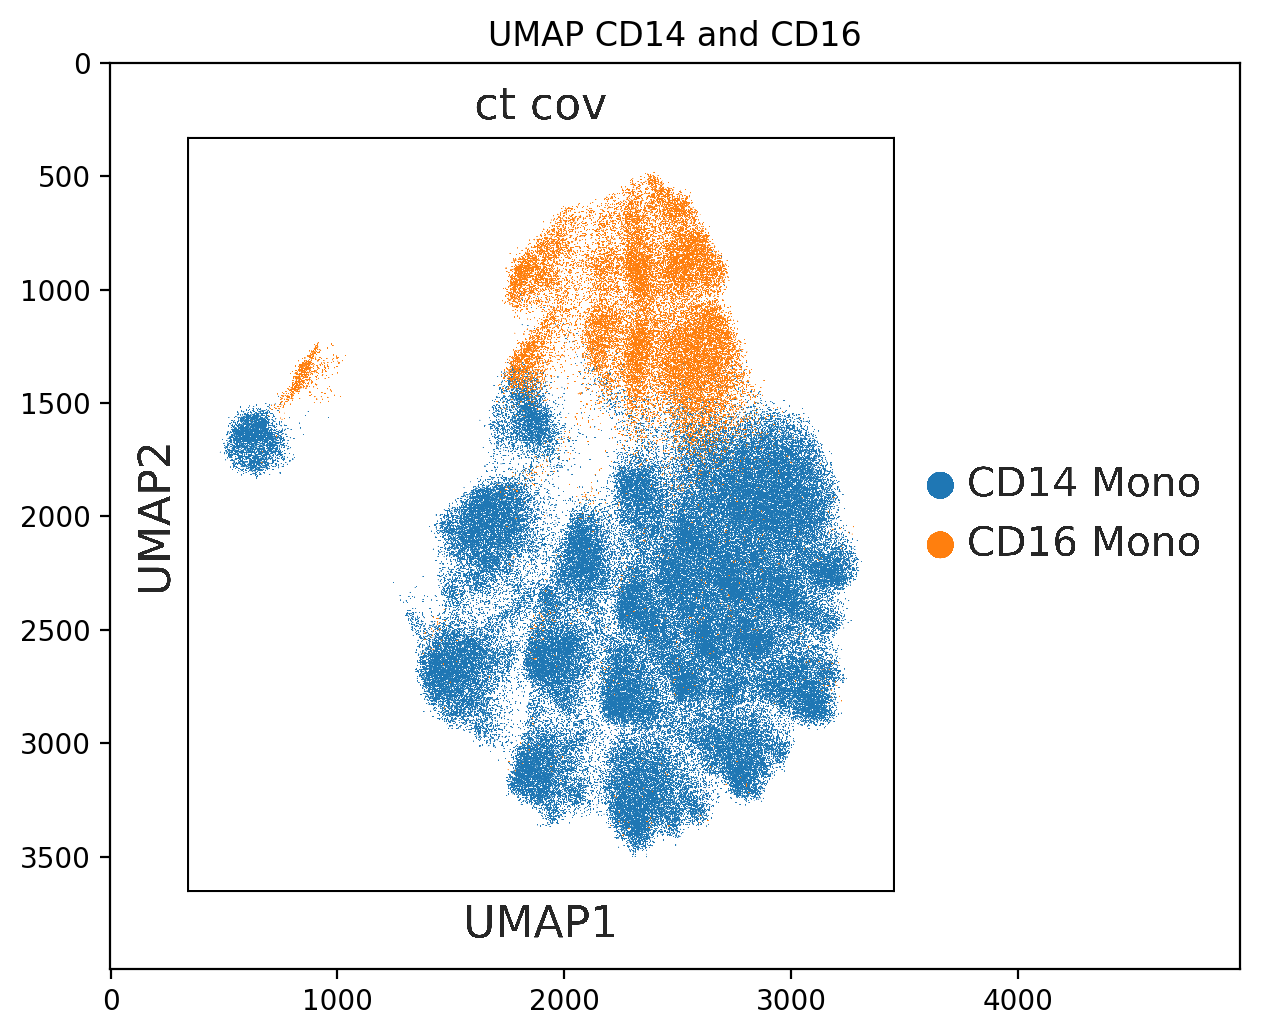

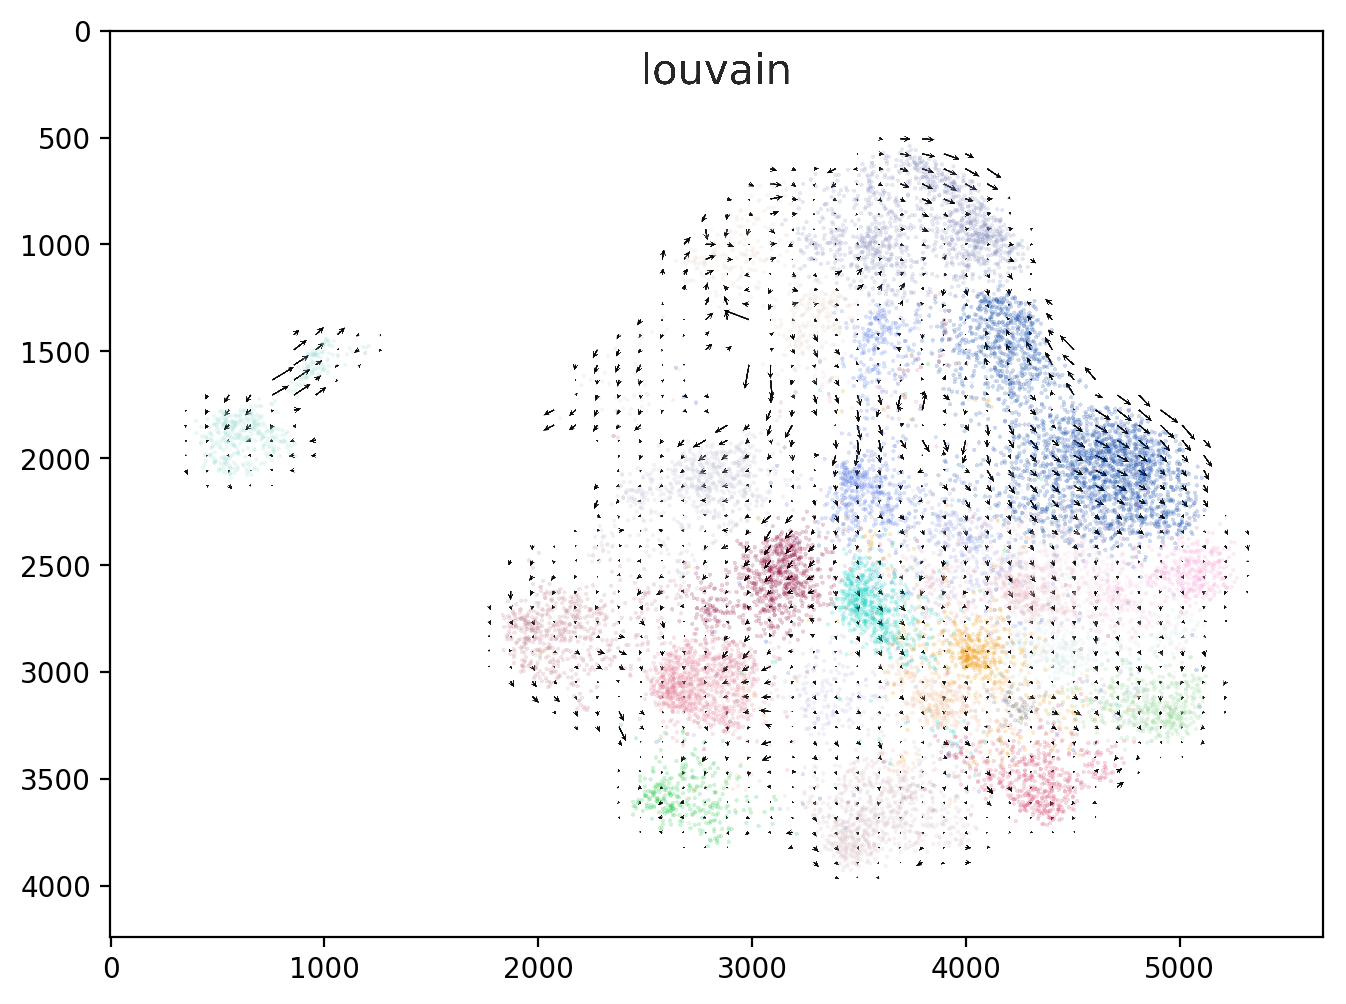

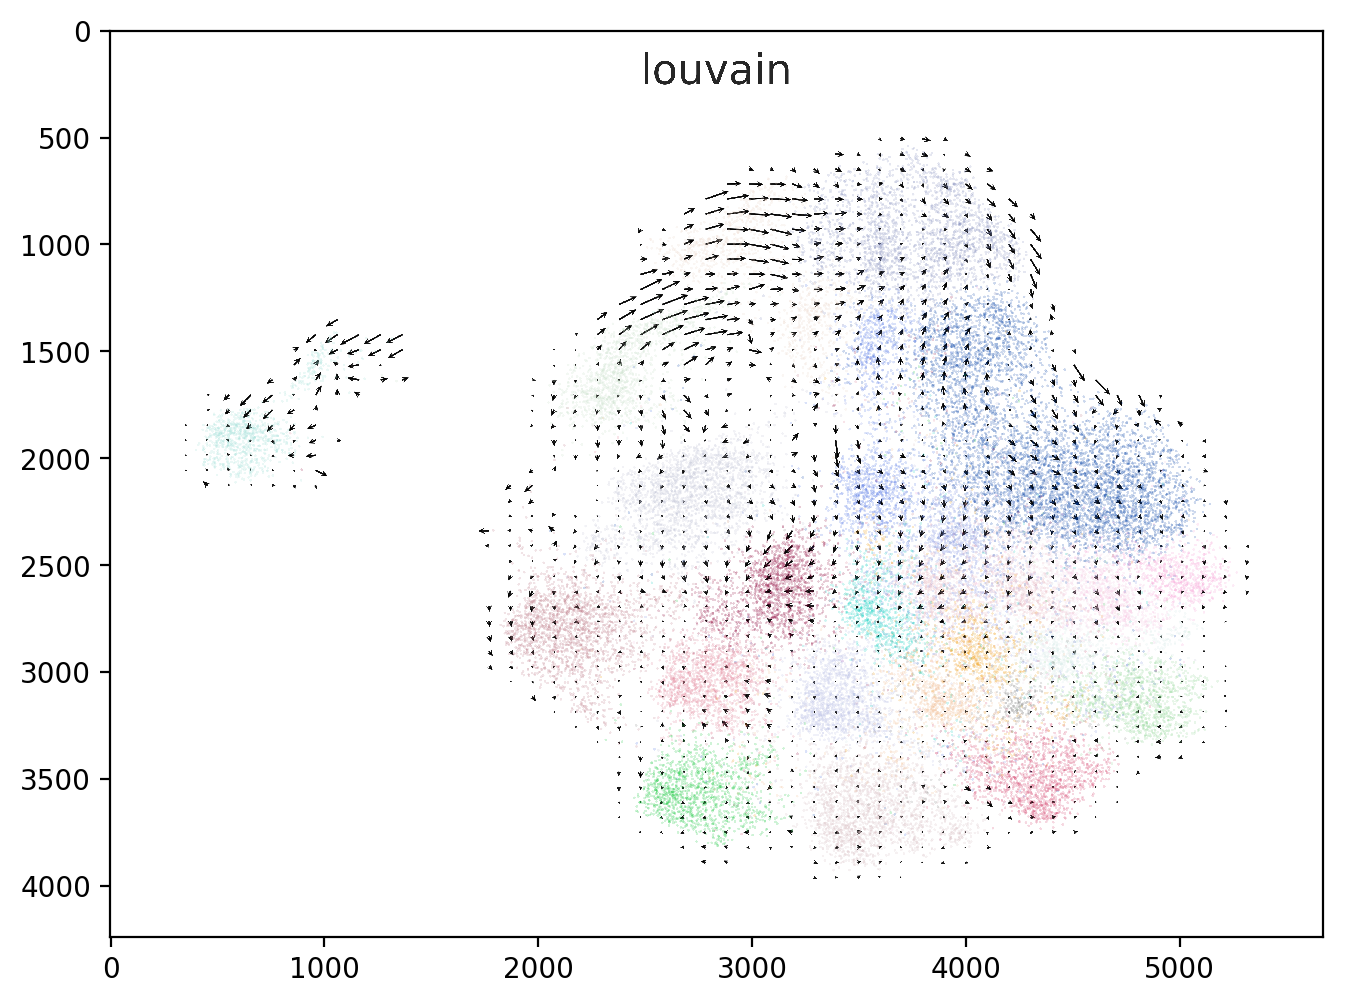

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('umapct_cov.png')
plt.title('UMAP CD14 and CD16')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
img=mpimg.imread('RNAvelocityhealthy.png')
plt.title('Healthy')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
img=mpimg.imread('RNAvelocitySLE.png')
plt.title('SLE')
imgplot = plt.imshow(img)

#### Histogram plots between interesting/potential trajectories

RNA velocity helped us identify trajectories between cell populations. Now using histograms and diffusion pseudotime, I want to show a difference in distributions between the two populations. Thinking back on it, I am not sure if this provides any addtional information to the analysis. It also does not work well.

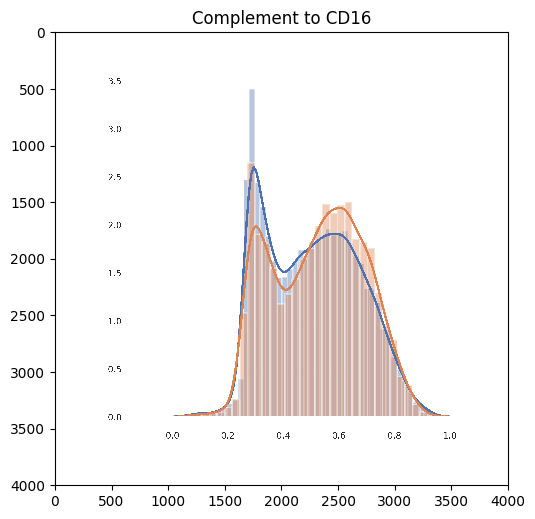

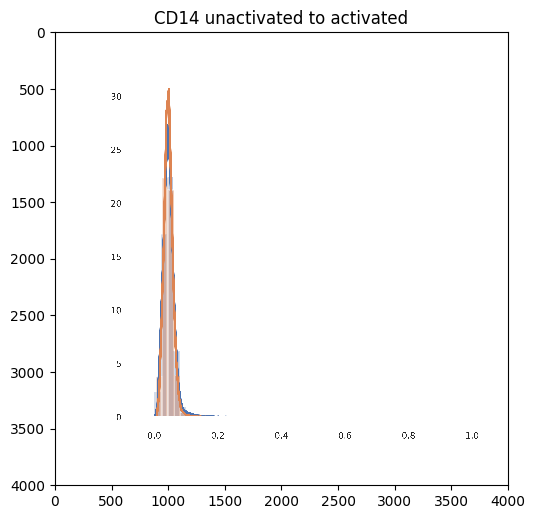

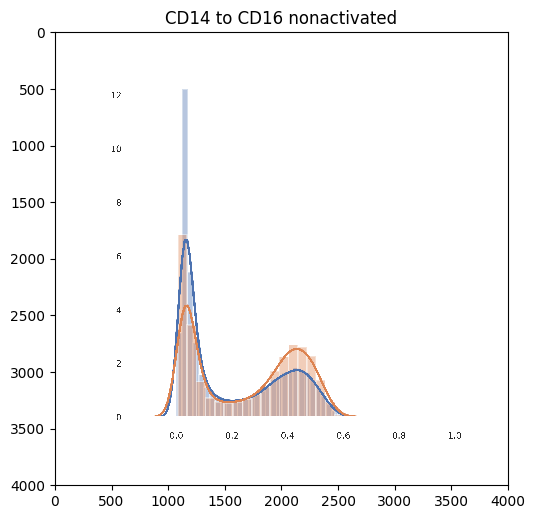

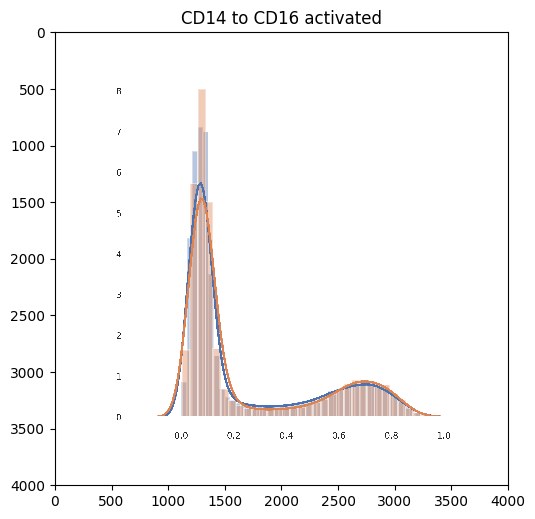

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('CD16_pseudotime_trajectory_histogram.png')
plt.title('Complement to CD16')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('CD14_pseudotime_trajectory_histogram.png')
plt.title('CD14 unactivated to activated')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('CD14CD16_nonactivated_pseudotime_trajectory_histogram.png')
plt.title('CD14 to CD16 nonactivated')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('CD14CD16_activated_pseudotime_trajectory_histogram.png')
plt.title('CD14 to CD16 activated')
imgplot = plt.imshow(img)

These look alright but not very interesting in part due to the limitations of diffusion pseudotime. Below are feature plots of pseudotime. The most compelling histograms are associated with pseudotime that best reflects the trajectory of interest.

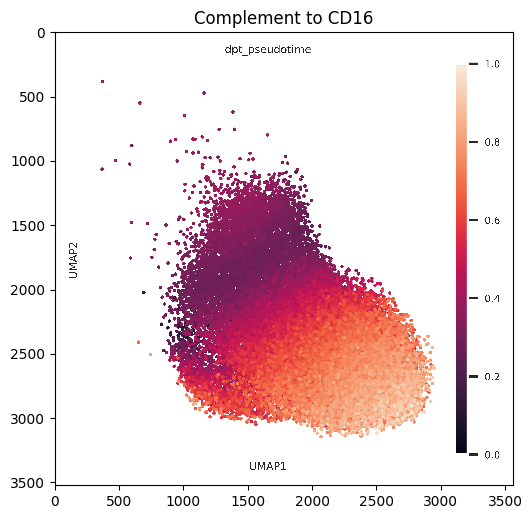

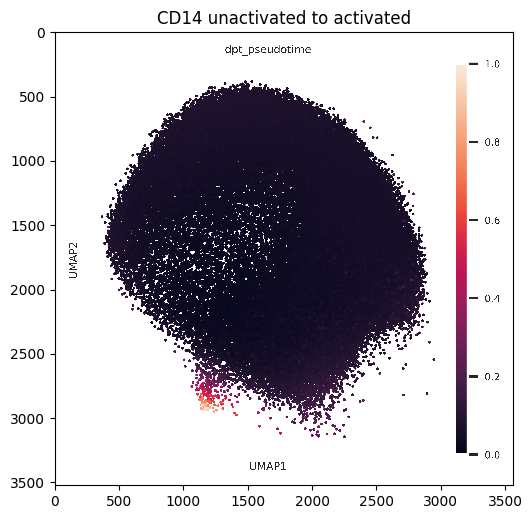

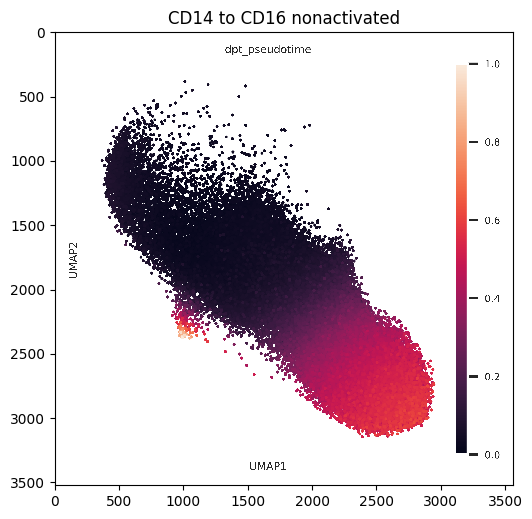

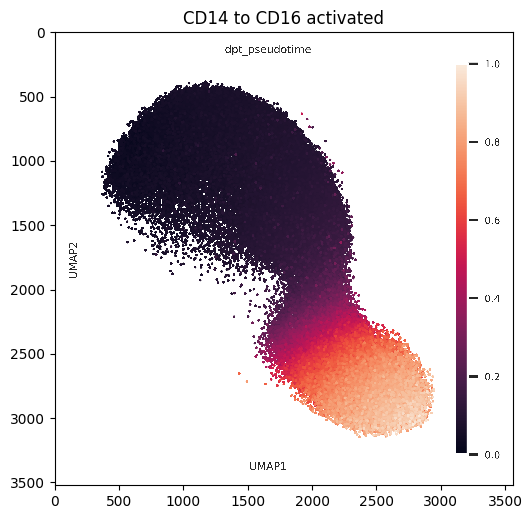

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('umapCD16_pseudotime_trajectory_histogram.png')
plt.title('Complement to CD16')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('umapCD14_pseudotime_trajectory_histogram.png')
plt.title('CD14 unactivated to activated')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('umapCD14CD16_nonactivated_pseudotime_trajectory_histogram.png')
plt.title('CD14 to CD16 nonactivated')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('umapCD14CD16_activated_pseudotime_trajectory_histogram.png')
plt.title('CD14 to CD16 activated')
imgplot = plt.imshow(img)

## Reflecting on psuedotime and moving forward with PAGA

I don't feel like pseudotime trajectory is offering much to the story and it is difficult to recover the differences we expect to see. 

I think a simpler representation of trajectories would best serve Figure 2 and 3. Using RNA velocity, we can recover transition confidence as well as connectivity. Using these components, we can contruct a PAGA graph with subpopulations linked by connectivity and trajectory directionality indicated by an arrow.

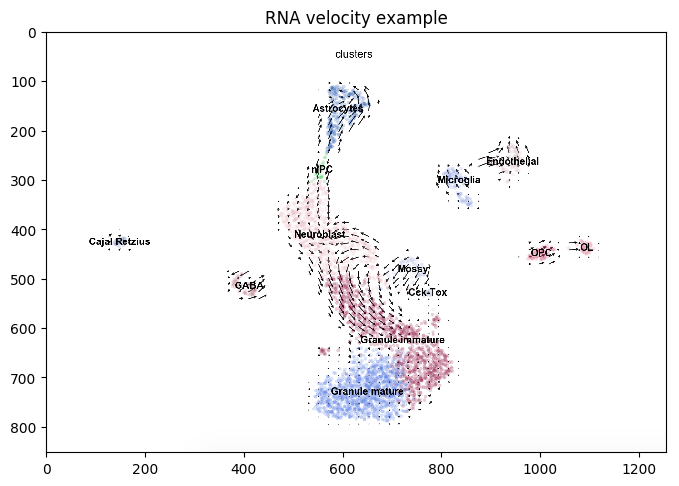

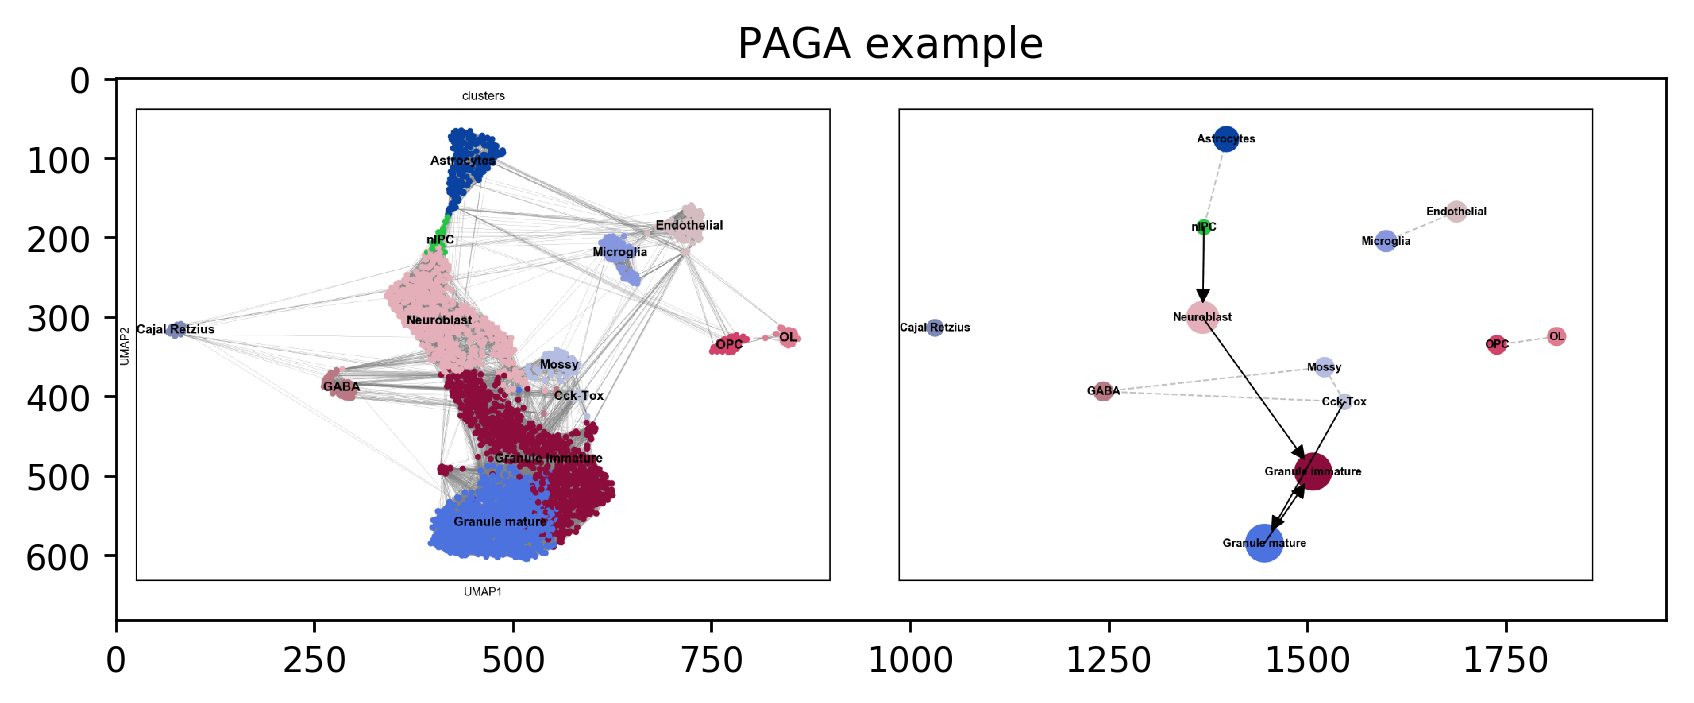

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
img=mpimg.imread('RNAvelocityexample.png')
plt.title('RNA velocity example')
imgplot = plt.imshow(img)

plt.figure(figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
img=mpimg.imread('PAGAexample.png')
plt.title('PAGA example')
imgplot = plt.imshow(img)